# CS 148 Final Project: Project 3

#### Contributors: Lea Alcantara & Andrea Casassa

## Background:
Cookies was founded in 2012 by Gilbert Anthony Milam Jr., better known by his stage name Berner, and his partner Jigga, Bay Area cultivator and breeder. The cofounder leveraged a unique confluence of emergent genetic engineering, internet culture, and strong associations with the music industry, to be one of the first companies to establish an identity and streetwear company that has come to dominate the industry.
Today, Cookies is one of the most respected and top-selling cannabis brands in California and is globally recognized, amassing a stable of over 50 cannabis varieties and product lines including indoor, outdoor and sungrown flower, pre-rolls, gel caps and vape carts. With two flagship Cookies stores in Los Angeles on Melrose and Maywood and a third location in Redding, Cookies' overall vertical integration and seed to sale business allows for complete quality control at every step from cultivation and production to retail experience.
In 2015, the brand's hip-hop credibility effortlessly expanded Cookies into streetwear and today offers a range of products for both men and women in the apparel and accessories categories as well as a curated selection of smoking supplies.

## Challenge:
You and your partner (yes you will be allowed to work in groups of up to 2!), will serve as consultants to Cookies. Having been provided with a complete set of cannabis sales data going back to 2018, along with detailed product descriptions for all brands sold in California, you will be asked to:
1. Develop a predictive model to help forecast product sales
2. Conduct an analysis to determine the key factors that likely impact the success of a product
and based on the data analysis propose potential growth areas to the company
This project will include both a structured component, where much like Projects 1 and 2, you will be given a specific set of instructions to complete. There will also be an unstructured component where we will ask you to experiment with your own approaches to see if you can maximize your own results.

## Project Requirements:  

## Specific Coding Requirements:
1. **Merge Datasets and Effectively Link information** - Useful information for this project will come from disparate datasets. You will need to effectively merge them into a single dataframe for analysis
2. **Develop basic Time Series Feature Extraction Plan** - develop a series of standard timeseries
features to augment your dataset and enable timeseries predictive models.
3. **Run some basic statistics on your variables including correlations with labels and report
findings** - Particularly once you employ PCA and other ‘black box’ methods, the descriptive power of any of your features will effectively disappear. Still you want to report out meaningful correlations toCookies to help them flag key indicators they can employ (this step will also be helpful for you in flagging potential co-linearities).
4. **Create additional data feature extraction plan and implement a comprehensive pipeline to execute it** - Determine and execute a plan to process your data for modeling and then implement a pipeline to execute it. Specifically:
    1. Determine which fields to retain and which to drop.
    2. For those you retain, determine a categorization strategy
    3. Determine an imputation strategy (you should choose more than one imputation
    method depending on the specifics of your data
    4. Augment at least one feature, ideally a feature cross, or non-linear transition e. Determine a strategy for scaling features
5. **Implement a single pipeline to execute this transformation**
6. **Document your data strategy in your report. Provide an explanation or justification for why
you chose the data you did, and also detail any experiments you ran and the results**
7. **Implement a basic Linear Regression predictive model** - With your newly pipelined data find
and interpret important features (e.g. using regression and associated p-values). If there are any
collinearities be careful when incorporating them into the regression.
8. **Implement Principle Component Analysis (PCA)** - Since your resulting dataframe is likely to be
high-dimensionality, employ PCA to reduce the complexity of your dataframe
9. **Employ an ensemble method to your predictive model exercise** - Leverage an ensemble
learning method to generate an optimized prediction model
10. **Cross-Validate your training results** - Employ K-Fold Cross-validation to your training regimen
for both ensemble and single regression models. (Optional: employ a stratifiedshufflesplit as
well to ensure equitable distribution along a key parameter)
11. **Employ a GridSearch method to optimize your parameters** - Leverage gridsearch or an
equivalent parameter tuning approach to optimize parameters to your predictive model (Note:
you can likely merge the gridsearch and cross-validation steps)
12. **Experiment with your own custom models and report out your highest performing model** -
For this part of the project you have free range to employ any of the tools you’ve learned in class, along with any additional tools or techniques you research independently to see how you can do.

### Loading Essential Functions

In [332]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

import os
import itertools
import random 

%matplotlib inline

random.seed(148)

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/"
DATA_PATH = GOOGLE_DRIVE_PATH + 'CS148_Final_Project/Raw_Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Goal 1: Develop Predictive Model to Predict Sales
Using **Time-Series Analysis**, use Monthly data to predict sales for future months.





## Coding Requirement 1: Data Merging

In [333]:
#Import all four datasets
price = pd.read_csv(DATA_PATH + 'BrandAverageRetailPrice.csv')
sales = pd.read_csv(DATA_PATH + 'BrandTotalSales.csv')
units = pd.read_csv(DATA_PATH + 'BrandTotalUnits.csv')
details = pd.read_csv(DATA_PATH + 'BrandDetails.csv')
top_50 = pd.read_csv(DATA_PATH + 'Top50ProductsbyTotalSales-Timeseries.csv')

In [334]:
#Filter the datasets on just the Brand 'Cookies' --> We determined that focusing on just Cookies does not provide enough information to get an accurate model
sales_cookie = sales.loc[sales['Brand'] == 'Cookies']
units_cookie = units.loc[units['Brands'] == 'Cookies']
price_cookie = price.loc[price['Brands'] == 'Cookies']

In [335]:
#Merge together the sales, units, and price datasets
merge1 = sales.merge(units, left_on= ['Months','Brand'], right_on=['Months', 'Brands'])
merge2 = merge1.merge(price, on=['Months','Brands'])

#Ended up determining that we no longer need this dataset. See documentation.

In [336]:
#Merge top50 to details to get the details for the top 50
details_monthly = (details.drop(columns=['Total Sales ($)']).merge(top_50, left_on='Product Description', right_on='Products', how='right', indicator=True).query('_merge == "both"').drop('_merge', 1))
details_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61763 entries, 0 to 61762
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                61763 non-null  object 
 1   Channel              61763 non-null  object 
 2   Category L1          61763 non-null  object 
 3   Category L2          61763 non-null  object 
 4   Category L3          61763 non-null  object 
 5   Category L4          9016 non-null   object 
 6   Category L5          6804 non-null   object 
 7   Brand                61763 non-null  object 
 8   Product Description  61763 non-null  object 
 9   Total Units          61763 non-null  object 
 10  ARP                  61763 non-null  float64
 11  Flavor               808 non-null    object 
 12  Items Per Pack       61763 non-null  int64  
 13  Item Weight          52272 non-null  object 
 14  Total THC            61763 non-null  object 
 15  Total CBD            61763 non-null 

## Coding Requirement 2: Develop Basic Time-Series Plan
- Feature Elimination: dropping the details dataset for most calculations, and Brands repeated columns
- Feature Extraction * (done after data cleaning)
- Modeling on the time series of Month

### Clean Formatting for Details Monthly Dataset

In [337]:
#Make the Months, Total Sales, and Total Units columns "system-friendly"
details_monthly['Months'] = pd.to_datetime(details_monthly['Months'])

details_monthly['Total Sales ($)'] = details_monthly['Total Sales ($)'].str[:8]
details_monthly.loc[:,"Total Sales ($)"] = details_monthly["Total Sales ($)"].str.replace(",","")
details_monthly['Total Sales ($)'] = pd.to_numeric(details_monthly['Total Sales ($)'])

details_monthly['Total Units'] = details_monthly['Total Units'].str[:8]
details_monthly.loc[:,"Total Units"] = details_monthly["Total Units"].str.replace(",","")
details_monthly['Total Units'] = pd.to_numeric(details_monthly['Total Units'])

In [338]:
#Drop unneccessary columns --> We can see that these columns are repeated the same for every row value and the Product is repeated in another column when we merged.
details_monthly = details_monthly.drop(columns=['State', 'Channel', 'Product Description'])

In [339]:
#Check for Nulls
details_monthly.isna().sum()

Category L1               0
Category L2               0
Category L3               0
Category L4           52747
Category L5           54959
Brand                     0
Total Units               0
ARP                       0
Flavor                60955
Items Per Pack            0
Item Weight            9491
Total THC                 0
Total CBD                 0
Contains CBD              0
Pax Filter            56075
Strain                60028
Is Flavored           60811
Mood Effect               0
Generic Vendor            0
Generic Items             0
$5 Price Increment        0
Products                  0
Months                    0
Total Sales ($)           0
dtype: int64

In [340]:
#Make the Total THC and Total CBD columns "system-friendly"
details_monthly['Total THC'] = pd.to_numeric(details_monthly['Total THC'])
details_monthly.loc[:,"Total CBD"] = details_monthly["Total CBD"].str.replace(",","")
details_monthly['Total CBD'] = pd.to_numeric(details_monthly['Total CBD'])

In [341]:
#Make the Item Weight "system-friendly"
with_mg = details_monthly.loc[details_monthly['Item Weight'].str.contains('mg', na=False)]
with_out_mg = details_monthly.loc[(~details_monthly['Item Weight'].str.contains('mg', na=False))]
with_mg.loc[:, 'Item Weight'] = with_mg['Item Weight'].str.strip().str.replace('mg', '').str.strip().astype(int)
with_mg['Item Weight'] = with_mg['Item Weight'].apply(lambda x: x/1000)
details_monthly = pd.concat([with_mg, with_out_mg]).sort_index(axis=0)
details_monthly['Item Weight'].unique()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([nan, '0.70', '1.00', '0.60', '0.30', '0.75', '0.50', '1.50',
       '0.25', '0.40', '1.16', '0.35', '1.40', '0.33', '0.65', '0.80',
       '0.20', '1.60', '1.25', '0.38', '1.75', '2.00', '1.30', '0.42',
       '1.20', '3.00', '0.58', '3.50', '0.37', '6.00', '2.20', '1.10',
       '7.00', 1.0, 0.5, 1.1, '8.00', '2.30', '3.20', '2.50', '5.00',
       '0.90', '1.70', '1.33', '3.30', '0.85', '2.40', '9.00', '3.85',
       '2.80', '2.15', 0.4, 1.5, 0.9, 0.3], dtype=object)

### Impute data that cannot be imputed in Pipeline

In [342]:
#Impute the Item Weight Column where NULL (L1 is Inhaleable) -->See reason in documentation
#L2 is 'Concentrates' 99
details_monthly.loc[(details_monthly['Item Weight'].isna()) & (details_monthly['Category L1'] == 'Inhaleables') & (details_monthly['Category L2'] == 'Concentrates'), ['Item Weight']] = 0.5
#L2 is 'Flower' 182
details_monthly.loc[(details_monthly['Item Weight'].isna()) & (details_monthly['Category L1'] == 'Inhaleables') & (details_monthly['Category L2'] == 'Flower'), ['Item Weight']] = 1.0

In [343]:
#Impute the Item Weight Column where NULL (L1 is Ingestible)
#Fill Item Weight where Total THC has values present
details_monthly.loc[(details_monthly['Item Weight'].isna()) & (details_monthly['Category L1'] == 'Ingestibles') & (details_monthly['Total THC']!=0), 'Item Weight'] = details_monthly['Total THC']
#Total THC is 0 and Total CBD is listed as 0, but Contains CBD and there are no CBD values listed (got values from product description)
details_monthly.loc[(details_monthly['Item Weight'].isna()) & (details_monthly['Category L1'] == 'Ingestibles') & (details_monthly['Total THC']==0) & (details_monthly['Total CBD'] == 0), ['Item Weight']] = 0.45

#Total THC is 0, but Contains CBD (Total CBD has a value)
details_monthly.loc[(details_monthly['Item Weight'].isna()) & (details_monthly['Category L1'] == 'Ingestibles'), ['Item Weight']] = details_monthly['Total CBD']

details_monthly["Item Weight"] = details_monthly["Item Weight"].astype(float)

In [344]:
#Check where item weight is still 0
details_monthly.loc[details_monthly['Item Weight'].isna() & (details_monthly['Total THC'] != 0), 'Item Weight'] = details_monthly['Total THC']
details_monthly.loc[details_monthly['Item Weight'].isna() & (details_monthly['Total CBD'] != 0), 'Item Weight'] = details_monthly['Total CBD']

details_monthly.loc[details_monthly['Item Weight'].isna(), 'Category L1'].unique() #only inhaleables and all accessories are left without weights

#Impute missing weights with info found from 'Product' column
details_monthly.loc[details_monthly['Item Weight'].isna() & details_monthly['Products'].str.contains('1.00g'), 'Item Weight']= 1.0

#Impute weight based on the missing values that are left, assume under $60 is 0.5 and above is 1.0g
details_monthly.loc[(details_monthly['Item Weight'].isna()& details_monthly['Brand'].str.contains('Stiiizy') & (details_monthly['$5 Price Increment'].str.contains('\$20|\$25'))), 'Item Weight'] = 0.5
details_monthly.loc[(details_monthly['Item Weight'].isna()& details_monthly['Brand'].str.contains('Stiiizy') & (details_monthly['$5 Price Increment'].str.contains('\$100'))), 'Item Weight'] = 1.0

details_monthly.loc[(details_monthly['Item Weight'].isna() & (details_monthly['$5 Price Increment'].str.contains('\$14|\$15|\$0|\$20|\$25|\$30|\$35|\$40|\$45|\$50|\$55|\$60'))), 'Item Weight'] = 0.5
details_monthly.loc[(details_monthly['Item Weight'].isna()), 'Item Weight'] = 1.0

In [345]:
##Check for other possible problematic features
details_monthly.isnull().sum()

Category L1               0
Category L2               0
Category L3               0
Category L4           52747
Category L5           54959
Brand                     0
Total Units               0
ARP                       0
Flavor                60955
Items Per Pack            0
Item Weight               0
Total THC                 0
Total CBD                 0
Contains CBD              0
Pax Filter            56075
Strain                60028
Is Flavored           60811
Mood Effect               0
Generic Vendor            0
Generic Items             0
$5 Price Increment        0
Products                  0
Months                    0
Total Sales ($)           0
dtype: int64

### Explore Column Formatting

In [346]:
#Make Categoery L1 column binary
details_monthly.loc[details_monthly['Category L1']=='All Accessories', 'Category L2'].unique() #check what type of product 'all accessories' is-->all inhaleables

#Set anything that is 'All Accessories' to be in the same category as Inhaleables
details_monthly.loc[details_monthly['Category L1']=='All Accessories', 'Category L1'] = 'Inhaleables'

#Check what is a topical to determine if it can be categorized as inheleable or ingestible
details_monthly.loc[details_monthly['Category L1']=='Topicals']# = 'Inhaleables'

details_monthly.loc[:,'Category L1'].unique()

array(['Inhaleables', 'Ingestibles', 'Topicals'], dtype=object)

In [347]:
#Check on Strain --> all NaN belongs to Ingestibles --> Strain not defined for them --> impute with zero/default
details_monthly.loc[details_monthly["Strain"].isna()]
details_monthly.loc[details_monthly["Strain"].isna(),"Strain"] = "Not Defined"

In [348]:
#Explore Generic Vendor column 
gv = details_monthly["Generic Vendor"].unique()
gv

array(['Generic Vendors', 'Non-Generic Vendors'], dtype=object)

In [349]:
#Explore Generic Items column 
gi = details_monthly["Generic Items"].unique()
gi

array(['Generic Items', 'Non-Generic Items'], dtype=object)

In [350]:
#Explore Category L2 column --> good, we'll one hot encode it
l2 = details_monthly["Category L2"].unique()
l2

array(['Flower', 'Pre-Rolled', 'Edibles', 'Concentrates', 'Devices',
       'Sublinguals', 'Topicals'], dtype=object)

In [351]:
#Explore Category L3 column --> too many categories --> reduce them or drop the feature 
details_monthly["Category L3"].value_counts()

Pre-Rolled               28440
Infused Pre-Rolled       18972
Vape                      5688
Hybrid                    1818
Vaporizers                1008
Dabbable Concentrates      864
Sativa                     756
Indica                     709
Candy                      664
Balms/Salves               612
Tinctures                  504
Indica Dominant            468
Indica Leaning             396
Sativa Dominant            360
Sativa Leaning             216
Chocolates                 144
Pills                      144
Name: Category L3, dtype: int64

In [352]:
#Drop them since they assume the same values
details_monthly = details_monthly.drop(["Generic Vendor","Generic Items"],axis=1)
#details_monthly.info()

### Some Simple Feature Extration

- Average Monthly ARP
- Total Units per Month

In [353]:
#Get product monthly ARP --> Accounting for the duplicate product values in details with different price points
details_monthly['Average Monthly ARP'] = details_monthly.groupby(['Months'])['ARP'].transform('mean')

In [354]:
#Get product monthly total units --> Ends up not being a significant feature
details_monthly['Total Units per Month'] = details_monthly.groupby([details_monthly['Months'].dt.date])['Total Units'].transform('sum')#.drop_duplicates()

## Prep Feature Extraction/Creation from Aggregate of Feature Count/Average per Month
- Essentially dummy encoding in a two part process where we cannot dummy encode in our pipeline

In [355]:
#Drop uneccessary columns where there are too many nulls
details_monthly = details_monthly.drop(["Flavor","Is Flavored","Pax Filter","Category L4","Category L5", 'Total THC', 'Total CBD', 'Total Units', 'ARP', 'Brand'],axis=1)

## Looking into the Categories to be Dummy Encoded
- Simplifying the categories to reduce dimentionality

In [356]:
#Identify unique values contained within L1
details_monthly.loc[:,'Category L1'].unique()

array(['Inhaleables', 'Ingestibles', 'Topicals'], dtype=object)

In [357]:
#Identify unique values contained within L2
details_monthly.loc[:,'Category L2'].unique()

#Reduce some features that should be in the same category, just named incorrectly
details_monthly.loc[(details_monthly['Category L2']=='Concentrates'), 'Category L2'] = 'Devices'
details_monthly.loc[:,'Category L2'].unique()

array(['Flower', 'Pre-Rolled', 'Edibles', 'Devices', 'Sublinguals',
       'Topicals'], dtype=object)

In [358]:
#Identify unique values contained within L3
#Reduce some features that should be in the same category, just named incorrectly
details_monthly.loc[(details_monthly['Category L3'].str.contains('Indica')), 'Category L3'] = 'Indica'
details_monthly.loc[(details_monthly['Category L3'].str.contains('Sativa')), 'Category L3'] = 'Sativa'
details_monthly.loc[details_monthly['Category L3'].str.contains('Tin|Balm'), 'Category L3'] = 'Tinctures/Balm'

#When the strain is not null, check the indica/sativa/hybrid content to impute Category L3
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa')) & (details_monthly['Strain'].str.contains('Blue Dream|Pineapple Express|Super Silver Haze')), 'Category L3'] = 'Sativa'
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa')) & (details_monthly['Strain'] == 'Skywalker OG'), 'Category L3'] = 'Indica'
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa')) & (details_monthly['Strain'] == 'OG Kush'), 'Category L3'] = 'Hybrid'

#If the product description mentions strain, impute
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa'))& (details_monthly['Products'].str.contains('Sativa')), 'Category L3'] = 'Sativa'
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa'))& (details_monthly['Products'].str.contains('Indica')), 'Category L3'] = 'Indica'
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa'))& (details_monthly['Products'].str.contains('Hybrid')), 'Category L3'] = 'Hybrid'

#The Product type implies strain
details_monthly.loc[(~details_monthly['Category L3'].str.contains('Hybrid|Indica|Sativa')) & (details_monthly['Category L3'].str.contains('Vap|Rolled|Chocolates|Candy|Dabbable Concentrates')), 'Category L3'] = 'Hybrid'

details_monthly.loc[:,'Category L3'].unique()

array(['Hybrid', 'Indica', 'Sativa', 'Tinctures/Balm'], dtype=object)

In [359]:
#Identify unique values contained within Items per Pack
details_monthly.loc[:,'Items Per Pack'].unique() #Only matters for Pre-Rolls

#Bin Item Values --> Determine that anything > 1 is a 'Pre-Roll' L2.
details_monthly.loc[(details_monthly['Items Per Pack'] == 0) & (details_monthly['Category L2']=='Pre-Rolled'), 'Items Per Pack'] = 1

#Fix binning to be 0 or 1
details_monthly.loc[(details_monthly['Items Per Pack'] == 0), 'Category L2'].unique()
details_monthly.loc[:,'Items Per Pack'].unique() 

#--> this feature ends up being of high importance, as it is the quantity purchased

array([ 0, 10,  5, 12,  2,  4,  1,  3,  7,  6,  9,  8, 14, 20])

In [360]:
#Identify unique values contained within Item Weight
details_monthly.loc[:,'Item Weight'].sort_values().unique()

#Determine binning of Item Weight to later drop where the bin is not signicant enough
details_monthly.loc[(details_monthly['Item Weight']<0.51), 'Item Weight String'] = '0.0-0.5g'
details_monthly.loc[(details_monthly['Item Weight']<1.1) & (details_monthly['Item Weight']>0.5), 'Item Weight String'] = '0.75-1.0g'
details_monthly.loc[(details_monthly['Item Weight']<1.6) & (details_monthly['Item Weight']>.99), 'Item Weight String'] = '1.0-1.5g'
details_monthly.loc[(details_monthly['Item Weight']<2.1) & (details_monthly['Item Weight']>1.4), 'Item Weight Strong'] = '1.5-2.0g'
details_monthly.loc[(details_monthly['Item Weight']<3.1) & (details_monthly['Item Weight']>1.9), 'Item Weight String'] = '2.0-3.0g'
details_monthly.loc[(details_monthly['Item Weight']<9.1) & (details_monthly['Item Weight'] > 3.0), 'Item Weight String'] = '3.0-9.0g'
details_monthly.loc[(details_monthly['Item Weight']<300) & (details_monthly['Item Weight'] > 10), 'Item Weight String'] = '15.0-300.0g'

details_monthly.loc[:,'Item Weight String'].value_counts()

1.0-1.5g       19591
0.0-0.5g       19440
0.75-1.0g      13752
2.0-3.0g        3492
3.0-9.0g        2268
15.0-300.0g     1852
Name: Item Weight String, dtype: int64

In [361]:
#Identify unique values contained within Contains CBD
details_monthly.loc[:,'Contains CBD'].unique() #categorical 

array(['THC Only', 'Contains CBD'], dtype=object)

In [362]:
#Identify unique values contained within Strain Types
details_monthly.loc[:,'Strain'].unique()

array(['Not Defined', 'Wedding Cake', '805 Glue', 'Biscotti', 'Gelonade',
       'Alien OG', 'Private Reserve OG', 'Durban Poison', 'Skywalker OG',
       'Blue Dream', 'OG Kush', 'Crescendo', 'Shotgun OG',
       'Super Silver Haze', 'Pineapple Express', 'Gushers', 'Quest'],
      dtype=object)

In [363]:
#Identify unique values contained within Mood Effect
details_monthly.loc[:,'Mood Effect'].value_counts()

Not Mood Specific    61122
Mood Specific          641
Name: Mood Effect, dtype: int64

In [364]:
#Identify unique values contained within $5 price Increment
details_monthly.loc[:,'$5 Price Increment'].unique()

#Add binning
details_monthly.loc[details_monthly['$5 Price Increment'].str.contains('\$0|\$14|\$19|\$24'), '$5 Price Increment'] = '$00.00-$24.99'
details_monthly.loc[details_monthly['$5 Price Increment'].str.contains('\$25|\$3|\$4'), '$5 Price Increment'] = '$25.00-$49.99'
details_monthly.loc[details_monthly['$5 Price Increment'].str.contains('\$5|\$6|\$70'), '$5 Price Increment'] = '$50.00-$74.99'
details_monthly.loc[details_monthly['$5 Price Increment'].str.contains('\$75|\$8|\$9'), '$5 Price Increment'] = '$75.00-$99.99'
details_monthly.loc[details_monthly['$5 Price Increment'].str.contains('100'),'$5 Price Increment'] = '$100+'
details_monthly.loc[:,'$5 Price Increment'].unique()

#Expect to see better feature importance with the higher price incremented items

array(['$75.00-$99.99', '$50.00-$74.99', '$00.00-$24.99', '$100+',
       '$25.00-$49.99'], dtype=object)

### Implement First Pass at dummy encoding to get New Features
- Must do this before running basic stats so we have numerical values

In [365]:
#Dummy Encode to get numerical values for our dataset
dummy = pd.get_dummies(details_monthly.drop(columns=['Products']))
dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61763 entries, 0 to 61762
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Items Per Pack                    61763 non-null  int64         
 1   Item Weight                       61763 non-null  float64       
 2   Months                            61763 non-null  datetime64[ns]
 3   Total Sales ($)                   61763 non-null  float64       
 4   Average Monthly ARP               61763 non-null  float64       
 5   Total Units per Month             61763 non-null  float64       
 6   Category L1_Ingestibles           61763 non-null  uint8         
 7   Category L1_Inhaleables           61763 non-null  uint8         
 8   Category L1_Topicals              61763 non-null  uint8         
 9   Category L2_Devices               61763 non-null  uint8         
 10  Category L2_Edibles               61763 non-nu

## Feature Augmentation

In [366]:
#Get Aggreate values from dummy df for Items Per Pack
dummy['Number of Pre-Rolls Per Pack'] = dummy.groupby('Months')['Items Per Pack'].transform('sum')
dummy = dummy.drop(columns=['Items Per Pack', 'Item Weight'])

In [367]:
#Get Aggreate values from dummy df for Contains CBD/THC
dummy['Count of Products w/CBD'] = dummy.groupby('Months')['Contains CBD_Contains CBD'].transform('sum')
dummy['Count of Products w/THC'] = dummy.groupby('Months')['Contains CBD_THC Only'].transform('sum')
dummy = dummy.drop(columns=['Contains CBD_Contains CBD', 'Contains CBD_THC Only'])

In [368]:
#Get Aggreate values from dummy df for Category L1
dummy['Count of Ingestibles'] = dummy.groupby('Months')['Category L1_Ingestibles'].transform('sum')
dummy['Count of Inhaleables'] = dummy.groupby('Months')['Category L1_Inhaleables'].transform('sum')
dummy['Count of Topicals'] = dummy.groupby('Months')['Category L1_Topicals'].transform('sum')

dummy = dummy.drop(columns=['Category L1_Ingestibles', 'Category L1_Inhaleables', 'Category L1_Topicals'])

In [369]:
#Get Aggreate values from dummy df for Category L2
dummy['Devices'] = dummy.groupby('Months')['Category L2_Devices'].transform('sum')
dummy['Edibles'] = dummy.groupby('Months')['Category L2_Edibles'].transform('sum')
dummy['Flower'] = dummy.groupby('Months')['Category L2_Flower'].transform('sum')
dummy['Pre-Rolled'] = dummy.groupby('Months')['Category L2_Pre-Rolled'].transform('sum')
dummy['Sublinguals'] = dummy.groupby('Months')['Category L2_Sublinguals'].transform('sum')
dummy['Topicals'] = dummy.groupby('Months')['Category L2_Topicals'].transform('sum')

dummy = dummy.drop(columns=['Category L2_Devices', 'Category L2_Edibles', 'Category L2_Flower', 'Category L2_Pre-Rolled', 'Category L2_Sublinguals', 'Category L2_Topicals'])

In [370]:
#Get Aggreate values from dummy df for Category L3
dummy['Hybrid'] = dummy.groupby('Months')['Category L3_Hybrid'].transform('sum')
dummy['Indica'] = dummy.groupby('Months')['Category L3_Indica'].transform('sum')
dummy['Sativa'] = dummy.groupby('Months')['Category L3_Sativa'].transform('sum')
dummy['Tincturs/Balm (L3-Strain Unknown)'] = dummy.groupby('Months')['Category L3_Tinctures/Balm'].transform('sum')

dummy = dummy.drop(columns=['Category L3_Hybrid', 'Category L3_Indica', 'Category L3_Sativa', 'Category L3_Tinctures/Balm'])

In [371]:
#Get Aggreate values from dummy df for Strain
dummy['Count Strain_805 Glue'] = dummy.groupby('Months')['Strain_805 Glue'].transform('sum')
dummy['Count Strain_Alien OG'] = dummy.groupby('Months')['Strain_Alien OG'].transform('sum')
dummy['Count Strain_Biscotti'] = dummy.groupby('Months')['Strain_Biscotti'].transform('sum')
dummy['Count Strain_Blue Dream'] = dummy.groupby('Months')['Strain_Blue Dream'].transform('sum')
dummy['Count Strain_Crescendo'] = dummy.groupby('Months')['Strain_Crescendo'].transform('sum')
dummy['Count Strain_Durban Poison'] = dummy.groupby('Months')['Strain_Durban Poison'].transform('sum')
dummy['Count Strain_Gelonade'] = dummy.groupby('Months')['Strain_Gelonade'].transform('sum')
dummy['Count Strain_Gushers'] = dummy.groupby('Months')['Strain_Gushers'].transform('sum')
dummy['Count Strain_Not Defined'] = dummy.groupby('Months')['Strain_Not Defined'].transform('sum')
dummy['Count Strain_OG Kush'] = dummy.groupby('Months')['Strain_OG Kush'].transform('sum')
dummy['Count Strain_Pineapple Express'] = dummy.groupby('Months')['Strain_Pineapple Express'].transform('sum')
dummy['Count Strain_Private Reserve OG'] = dummy.groupby('Months')['Strain_Private Reserve OG'].transform('sum')
dummy['Count Strain_Quest'] = dummy.groupby('Months')['Strain_Quest'].transform('sum')
dummy['Count Strain_Shotgun OG'] = dummy.groupby('Months')['Strain_Shotgun OG'].transform('sum')
dummy['Count Strain_Skywalker OG'] = dummy.groupby('Months')['Strain_Skywalker OG'].transform('sum')
dummy['Count Strain_Super Silver Haze'] = dummy.groupby('Months')['Strain_Super Silver Haze'].transform('sum')
dummy['Count Strain_Wedding Cake'] = dummy.groupby('Months')['Strain_Wedding Cake'].transform('sum')

dummy = dummy.drop(columns=['Strain_805 Glue',	'Strain_Alien OG',	'Strain_Biscotti',	'Strain_Blue Dream',	'Strain_Crescendo',	'Strain_Durban Poison',	'Strain_Gelonade',	'Strain_Gushers',	'Strain_Not Defined',	'Strain_OG Kush',	'Strain_Pineapple Express',	'Strain_Private Reserve OG',	'Strain_Quest',	'Strain_Shotgun OG',	'Strain_Skywalker OG',	'Strain_Super Silver Haze',	'Strain_Wedding Cake'])

In [372]:
#Get Aggreate values from dummy df for Mood
dummy['Mood Specific'] = dummy.groupby('Months')['Mood Effect_Mood Specific'].transform('sum')

dummy = dummy.drop(columns=['Mood Effect_Mood Specific', 'Mood Effect_Not Mood Specific'])

In [373]:
#Get Aggreate values from dummy df for Price Range
dummy['Count $00.00-$24.99'] = dummy.groupby('Months')['$5 Price Increment_$00.00-$24.99'].transform('sum')
dummy['Count $100+'] = dummy.groupby('Months')['$5 Price Increment_$100+'].transform('sum')
dummy['Count $$25.00-$49.99'] = dummy.groupby('Months')['$5 Price Increment_$25.00-$49.99'].transform('sum')
dummy['Count $50.00-$74.99'] = dummy.groupby('Months')['$5 Price Increment_$50.00-$74.99'].transform('sum')
dummy['Count $75.00-$99.99'] = dummy.groupby('Months')['$5 Price Increment_$75.00-$99.99'].transform('sum')

dummy = dummy.drop(columns=['$5 Price Increment_$00.00-$24.99',	'$5 Price Increment_$100+',	'$5 Price Increment_$25.00-$49.99',	'$5 Price Increment_$50.00-$74.99',	'$5 Price Increment_$75.00-$99.99'])

In [374]:
#Get Aggreate values from dummy df for Item Weight Range
dummy['Count 0.0-0.5g'] = dummy.groupby('Months')['Item Weight String_0.0-0.5g'].transform('sum')
dummy['Count 0.75-1.0g'] = dummy.groupby('Months')['Item Weight String_0.75-1.0g'].transform('sum')
dummy['Count 1.0-1.5g'] = dummy.groupby('Months')['Item Weight String_1.0-1.5g'].transform('sum')
dummy['Count 2.0-3.0g'] = dummy.groupby('Months')['Item Weight String_2.0-3.0g'].transform('sum')
dummy['Count 15.0-300.0g'] = dummy.groupby('Months')['Item Weight String_15.0-300.0g'].transform('sum')
dummy['Count 3.0-9.0g'] = dummy.groupby('Months')['Item Weight String_3.0-9.0g'].transform('sum')
dummy['Count 1.5-2.0g'] = dummy.groupby('Months')['Item Weight Strong_1.5-2.0g'].transform('sum')

dummy = dummy.drop(columns=['Item Weight Strong_1.5-2.0g','Item Weight String_3.0-9.0g','Item Weight String_2.0-3.0g','Item Weight String_15.0-300.0g','Item Weight String_0.0-0.5g',	'Item Weight String_0.75-1.0g',	'Item Weight String_1.0-1.5g'])

In [375]:
#Complete manual aggregation
df = dummy.drop_duplicates('Months').sort_values('Months').reset_index(drop=True)

## Coding Requirement 3: Basic Stats


In [376]:
#Run the basic stats for our new, raw table
df.set_index("Months").describe()

,Total Sales ($),Average Monthly ARP,Total Units per Month,Number of Pre-Rolls Per Pack,Count of Products w/CBD,Count of Products w/THC,Count of Ingestibles,Count of Inhaleables,Count of Topicals,Devices,Edibles,Flower,Pre-Rolled,Sublinguals,Topicals,Hybrid,Indica,Sativa,Tincturs/Balm (L3-Strain Unknown),Count Strain_805 Glue,Count Strain_Alien OG,Count Strain_Biscotti,Count Strain_Blue Dream,Count Strain_Crescendo,Count Strain_Durban Poison,Count Strain_Gelonade,Count Strain_Gushers,Count Strain_Not Defined,Count Strain_OG Kush,Count Strain_Pineapple Express,Count Strain_Private Reserve OG,Count Strain_Quest,Count Strain_Shotgun OG,Count Strain_Skywalker OG,Count Strain_Super Silver Haze,Count Strain_Wedding Cake,Mood Specific,Count $00.00-$24.99,Count $100+,Count $$25.00-$49.99,Count $50.00-$74.99,Count $75.00-$99.99,Count 0.0-0.5g,Count 0.75-1.0g,Count 1.0-1.5g,Count 2.0-3.0g,Count 15.0-300.0g,Count 3.0-9.0g,Count 1.5-2.0g
count,36.000000,36.000000,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.0,36.0,36.000000,36.000000,36.0,36.0,36.0,36.000000,36.000000,36.000000,36.0,36.000000,36.0,36.000000,36.0,36.000000,36.0,36.000000,36.0,36.000000,36.0,36.0,36.000000,36.0,36.000000,36.0,36.0,36.000000,36.000000,36.000000,36.000000,36.0,36.0,36.0,36.0,36.0,36.000000,36.0,36.000000,36.0,36.0
mean,187800.944444,33.781928,2.022496e+07,6244.500000,240.500000,1475.138889,40.444444,1658.194444,17.0,210.0,26.444444,131.194444,1317.0,14.0,17.0,1575.583333,54.333333,54.722222,31.0,2.083333,3.0,3.777778,8.0,1.722222,3.0,4.583333,4.0,1667.444444,2.0,3.0,2.833333,3.0,0.861111,4.0,1.0,1.333333,17.805556,639.833333,156.805556,599.0,235.0,85.0,540.0,382.0,544.194444,97.0,51.444444,63.0,116.0
std,20257.792709,0.119146,2.254215e+06,65.959945,0.971008,9.074778,4.982509,5.192409,0.0,0.0,4.982509,5.192409,0.0,0.0,0.0,7.287465,2.354327,0.701472,0.0,1.401530,0.0,0.929243,0.0,0.701472,0.0,1.401530,0.0,4.982509,0.0,0.0,0.696932,0.0,0.350736,0.0,0.0,0.956183,1.737312,8.787979,1.214659,0.0,0.0,0.0,0.0,0.0,5.192409,0.0,4.982509,0.0,0.0
min,147478.000000,33.699584,1.411866e+07,6032.000000,238.000000,1446.000000,26.000000,1641.000000,17.0,210.0,12.000000,114.000000,1317.0,14.0,17.0,1552.000000,48.000000,53.000000,31.0,0.000000,3.0,0.000000,8.0,0.000000,3.0,0.000000,4.0,1653.000000,2.0,3.0,0.000000,3.0,0.000000,4.0,1.0,0.000000,11.000000,612.000000,153.000000,599.0,235.0,85.0,540.0,382.0,527.000000,97.0,37.000000,63.0,116.0
25%,173666.750000,33.699584,1.963644e+07,6232.000000,241.000000,1472.000000,40.000000,1656.000000,17.0,210.0,26.000000,129.000000,1317.0,14.0,17.0,1573.000000,54.000000,55.000000,31.0,0.000000,3.0,4.000000,8.0,2.000000,3.0,5.000000,4.0,1667.000000,2.0,3.0,3.000000,3.0,1.000000,4.0,1.0,0.000000,17.000000,638.000000,156.000000,599.0,235.0,85.0,540.0,382.0,542.000000,97.0,51.000000,63.0,116.0
50%,188396.000000,33.723604,2.134511e+07,6272.000000,241.000000,1479.000000,42.000000,1661.000000,17.0,210.0,28.000000,134.000000,1317.0,14.0,17.0,1580.000000,54.000000,55.000000,31.0,3.000000,3.0,4.000000,8.0,2.000000,3.0,5.000000,4.0,1669.000000,2.0,3.0,3.000000,3.0,1.000000,4.0,1.0,2.000000,19.000000,644.000000,157.000000,599.0,235.0,85.0,540.0,382.0,547.000000,97.0,53.000000,63.0,116.0
75%,201265.000000,33.824712,2.195599e+07,6302.000000,241.000000,1482.000000,45.000000,1661.000000,17.0,210.0,31.000000,134.000000,1317.0,14.0,17.0,1580.000000,57.000000,55.000000,31.0,3.000000,3.0,4.000000,8.0,2.000000,3.0,5.000000,4.0,1672.000000,2.0,3.0,3.000000,3.0,1.000000,4.0,1.0,2.000000,19.000000,646.000000,158.000000,599.0,235.0,85.0,540.0,382.0,547.000000,97.0,56.000000,63.0,116.0
max,227384.000000,34.157310,2.195599e+07,6302.000000,241.000000,1482.000000,45.000000,1661.000000,17.0,210.0,31.000000,134.000000,1317.0,14.0,17.0,1580.000000,57.000000,55.000000,31.0,3.000000,3.0,4.000000,8.0,2.000000,3.0,5.000000,4.0,1672.000000,2.0,3.0,3.000000,3.0,1.000000,4.0,1.0,2.000000,19.000000,646.000000,158.000000,599.0,235.0,85.0,540.0,382.0,547.000000,97.0

In [377]:
#Prepare code for Correlation Matrix
df_copy = df.copy().drop(columns=['Pre-Rolled','Count 2.0-3.0g','Tincturs/Balm (L3-Strain Unknown)', 'Sublinguals','Count 0.0-0.5g','Count 0.75-1.0g', 'Count of Topicals', 'Devices', 'Topicals', 'Count $$25.00-$49.99','Count $50.00-$74.99','Count $75.00-$99.99', 'Count Strain_Alien OG', 'Count Strain_Blue Dream', 'Count Strain_Durban Poison', 'Count Strain_Gushers', 'Count Strain_OG Kush', 'Count Strain_Pineapple Express', 'Count Strain_Quest', 'Count Strain_Skywalker OG', 'Count Strain_Super Silver Haze'])

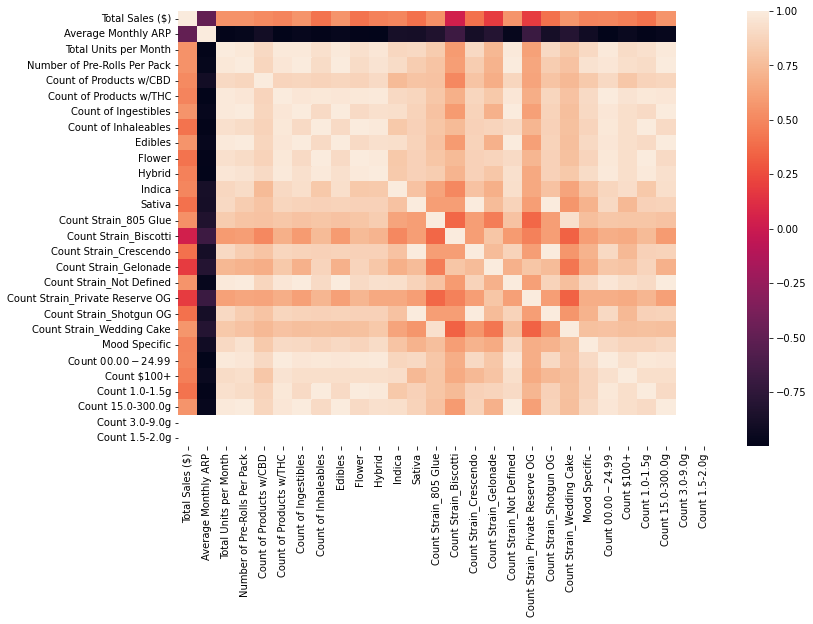

In [378]:
#Correlation Matrix showing high multicollinearity, which is expected in the first pass due to the date range
import seaborn as sns

corr = df_copy.corr()

plt.subplots(figsize=(12,8))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Run model to check for colinearity

In [379]:
#Remove the target variable from the dataset before pipelining remainder of the dataset
y_base = df[['Total Sales ($)']].copy()
x_base = df.drop(columns=['Total Sales ($)'])

In [380]:
#Simple pipline just to standardize to check for colinearity
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler #check the impact of different scaling types

from sklearn.compose import ColumnTransformer, make_column_transformer
imputer = SimpleImputer(strategy="mean") # use mean imputation for missing values
base_num = x_base.drop(['Months'], axis=1) 

# remove categorical features from the numeric values

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', MinMaxScaler())
    ])

avocado_num_tr = num_pipeline.fit_transform(base_num)
numerical_features = list(base_num)
categorical_features = ['Months']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features)#,
        #("cat", OneHotEncoder(categories='auto'), categorical_features),
    ])

base_prepared = full_pipeline.fit_transform(x_base)

In [381]:
#Scale the target variable outside of the pipeline so we do not interfere
sc = MinMaxScaler()
y_base = np.array(y_base)
y_base = y_base.reshape(-1,1)
y_labels = sc.fit_transform(y_base)

## Ordinary Least Squares on Base Model

In [382]:
# build the OLS model (ordinary least squares) from the training data
base_stats = sm.OLS(y_labels, base_prepared)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = base_stats.fit()

# do the fit and save regression info (parameters, etc) in results_stats
print(results_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.527
Date:                Sun, 05 Dec 2021   Prob (F-statistic):             0.0293
Time:                        04:29:40   Log-Likelihood:                 11.401
No. Observations:                  36   AIC:                           -0.8025
Df Residuals:                      25   BIC:                             16.62
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5183      0.212      2.450      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


## Coding Requirement 4: Additional Feature Extraction & Pipeline

**Features to Add:**

1. Previous Month: The previous months Total Sales
2. Rolling Average: The average Total Sales for the previous 3 months

- Categorization Strategy, Imputation, and other feature augmentation done previously ^

### Final Feature Agumentation

In [383]:
#Augment the feature for previous month on total units prior to the for loop on each brand
df.loc[:, 'Previous Month'] = df.loc[:, 'Total Sales ($)'].shift(1)

In [384]:
#Augment the Rolling Average Feature on Total Units
df.loc[:, 'Rolling Average'] = df.loc[:, 'Total Sales ($)'].rolling(3, min_periods=2).mean()

#Impute the nulls values from the first instances of the Rolling Average where there is no value to be averaged and set as the first instance of total units
df.loc[df['Rolling Average'].isna(), 'Rolling Average'] = df['Total Sales ($)']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Months                             36 non-null     datetime64[ns]
 1   Total Sales ($)                    36 non-null     float64       
 2   Average Monthly ARP                36 non-null     float64       
 3   Total Units per Month              36 non-null     float64       
 4   Number of Pre-Rolls Per Pack       36 non-null     int64         
 5   Count of Products w/CBD            36 non-null     uint8         
 6   Count of Products w/THC            36 non-null     float64       
 7   Count of Ingestibles               36 non-null     uint8         
 8   Count of Inhaleables               36 non-null     float64       
 9   Count of Topicals                  36 non-null     uint8         
 10  Devices                            36 no

In [385]:
#Drop features that have the same value for every month
df = df.drop(columns=['Count of Topicals', 'Devices', 'Pre-Rolled', 'Sublinguals', 'Topicals', 'Tincturs/Balm (L3-Strain Unknown)', 'Count $$25.00-$49.99', 'Count $50.00-$74.99', 'Count $75.00-$99.99', 'Count 0.0-0.5g', 'Count 0.75-1.0g', 'Count 3.0-9.0g', 'Count 1.5-2.0g','Count 2.0-3.0g'])

## Coding Requirement 5 Pipeline

In [386]:
#Remove the target variable from the dataset before pipelining remainder of the dataset
y = df[['Total Sales ($)']].copy()
x = df.drop(columns=['Total Sales ($)'])

In [387]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

imputer = SimpleImputer(strategy="mean") # use mean imputation for missing values

data_num = x.drop(columns=['Months']) #Determine and split the numerical features

#Choose Scaling Strategy
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', MinMaxScaler()),
    ])

df_num_tr = num_pipeline.fit_transform(data_num)
numerical_features = list(data_num)
categorical_features = ['Months']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features)#,
        #("cat", OneHotEncoder(), categorical_features),
    ])

data_prepared = full_pipeline.fit_transform(x)#.toarray()

In [388]:
#Scale the target variable
sc = MinMaxScaler()
y = np.array(y)
y1 = y.reshape(-1,1)
y_labels = sc.fit_transform(y1)

In [389]:
# build the OLS model (ordinary least squares) from the training data
stats = sm.OLS(y_labels, data_prepared)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = stats.fit()
print(results_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     12.08
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           3.13e-07
Time:                        04:29:40   Log-Likelihood:                 34.618
No. Observations:                  36   AIC:                            -43.24
Df Residuals:                      23   BIC:                            -22.65
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1417      0.133      1.069      0.2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


## Coding Requirement 7: Linear Regression Model and Feature Importance

### Implement Train/Test Split from the Pipelined and Prepared data

In [390]:
#Create a df from the pipelined array created to maintain feature importance
x_months = x.set_index('Months') #Set the index to Months
data_prepared_df = pd.DataFrame(data=data_prepared, columns=x_months.columns)
data_prepared_df['Months'] = x_months.index
data_prepared_df['Total Sales ($)'] = y_labels

In [391]:
#Train/test split on the months so we can test on the month of september
train_df = data_prepared_df.loc[(data_prepared_df['Months']!='2021-09-01')&(data_prepared_df['Months']!='2021-08-01')].set_index('Months')
test_df = data_prepared_df.loc[(data_prepared_df['Months']=='2021-09-01')|(data_prepared_df['Months']=='2021-08-01')].set_index('Months')

In [392]:
#Drop any features with p-values as nan or near 1
train_df = train_df.drop(columns=['Total Units per Month','Count Strain_805 Glue','Count 1.0-1.5g','Flower','Count of Inhaleables','Count Strain_Alien OG', 'Count Strain_Blue Dream', 'Count Strain_Durban Poison', 'Count Strain_Gushers', 'Count Strain_OG Kush', 'Count Strain_Pineapple Express', 'Count Strain_Quest', 'Count Strain_Skywalker OG', 'Count Strain_Super Silver Haze'])
test_df = test_df.drop(columns=['Total Units per Month','Count Strain_805 Glue','Count 1.0-1.5g','Flower','Count of Inhaleables','Count Strain_Alien OG', 'Count Strain_Blue Dream', 'Count Strain_Durban Poison', 'Count Strain_Gushers', 'Count Strain_OG Kush', 'Count Strain_Pineapple Express', 'Count Strain_Quest', 'Count Strain_Skywalker OG', 'Count Strain_Super Silver Haze'])

In [393]:
# create training sets 
y_train = train_df[['Total Sales ($)']]
X_train = train_df.drop(columns=['Total Sales ($)'], axis=1)

In [394]:
#Create test sets
y_test = test_df['Total Sales ($)']
X_test = test_df.drop(columns=['Total Sales ($)'], axis =1)

In [395]:
from sklearn.linear_model import LinearRegression

# fit a model based on our train/test split between months
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions_linear = lm.predict(X_test)

In [396]:
#Check MSE for linear model
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions_linear)
mae = mean_absolute_error(y_test, predictions_linear)
print('MSE For Basic Linear Regression Model', mse)
print('MAE for basic Linear Regression Model', mae)

MSE For Basic Linear Regression Model 0.01049821270288932
MAE for basic Linear Regression Model 0.10239183537793406


In [397]:
# build the OLS model (ordinary least squares) 
stats = sm.OLS(y_train, X_train)
# do the fit and save regression info (parameters, etc) in results_stats
results_stats = stats.fit()
print(results_stats.summary())

                                 OLS Regression Results                                
Dep. Variable:        Total Sales ($)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              66.03
Date:                Sun, 05 Dec 2021   Prob (F-statistic):                    2.16e-14
Time:                        04:29:41   Log-Likelihood:                          32.646
No. Observations:                  34   AIC:                                     -41.29
Df Residuals:                      22   BIC:                                     -22.97
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

## Coding Requirement: 8 Implement PCA

In [399]:
from sklearn import decomposition
from sklearn.decomposition import PCA
# First we create a PCA object with the 7 components as a parameter
pca = decomposition.PCA(n_components=7)

# Now we run the fit operation to convert our 
# data to a PCA transformmed data
pca.fit_transform(np.asarray(train_df))

#Convert to a dataframe to identify some form of correlation to the column values
pca_df = pd.DataFrame(pca.components_,columns=train_df.columns,index = ['PC-1','PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7'])#.drop(columns=['Count Strain_Alien OG', 'Count Strain_Blue Dream', 'Count Strain_Durban Poison', 'Count Strain_Gushers', 'Count Strain_OG Kush', 'Count Strain_Pineapple Express', 'Count Strain_Quest', 'Count Strain_Skywalker OG', 'Count Strain_Super Silver Haze'])
pca_df

,Average Monthly ARP,Number of Pre-Rolls Per Pack,Count of Products w/CBD,Count of Products w/THC,Count of Ingestibles,Edibles,Hybrid,Indica,Sativa,Count Strain_Biscotti,Count Strain_Crescendo,Count Strain_Gelonade,Count Strain_Not Defined,Count Strain_Private Reserve OG,Count Strain_Shotgun OG,Count Strain_Wedding Cake,Mood Specific,Count $00.00-$24.99,Count $100+,Count 15.0-300.0g,Previous Month,Rolling Average,Total Sales ($)
PC-1,0.217817,-0.200019,-0.249698,-0.210132,-0.215008,-0.215008,-0.215796,-0.192459,-0.269715,-0.125724,-0.269715,-0.184542,-0.215008,-0.130146,-0.269715,-0.321078,-0.164420,-0.216926,-0.187677,-0.215008,-0.095680,-0.128586,-0.119959
PC-2,-0.022399,-0.025038,-0.033456,0.030220,-0.016939,-0.016939,0.009988,0.024820,0.242243,0.202189,0.242243,0.274051,-0.016939,0.204351,0.242243,-0.484133,-0.044273,0.032141,-0.021051,-0.016939,-0.352651,-0.443821,-0.319415
PC-3,-0.092859,0.021940,0.015543,0.075864,-0.042891,-0.042891,0.142585,-0.067930,-0.301628,0.229312,-0.301628,0.205241,-0.042891,0.188157,-0.301628,0.477418,0.175916,0.055895,0.175465,-0.042891,-0.178614,-0.297723,-0.369077
PC-4,-0.003631,0.059353,-0.008351,0.039820,0.042422,0.042422,0.005353,0.191439,-0.232195,0.279636,-0.232195,0.319678,0.042422,0.247958,-0.232195,-0.526040,0.099565,0.010957,0.207186,0.042422,0.382020,0.254351,0.083697
PC-5,0.016371,0.063756,0.113075,-0.025988,0.048451,0.048451,-0.092585,0.246098,-0.109417,-0.503696,-0.109417,-0.045089,0.048451,0.526533,-0.109417,-0.058253,0.100106,-0.022297,0.032351,0.048451,-0.475998,0.004407,0.305339
PC-6,0.036483,0.194048,-0.352426,0.046342,0.233586,0.233586,-0.113890,0.436679,-0.065066,-0.058234,-0.065066,-0.402718,0.233586,-0.239832,-0.065066,-0.095080,0.100146,-0.004251,0.151117,0.233586,-0.007715,-0.157922,-0.331719
PC-7,-0.019511,-0.049430,-0.664996,0.077384,-0.044339,-0.044339,-0.011112,0.117106,0.024005,0.296189,0.024005,0.205760,-0.044339,-0.129692,0.024005,0.141115,-0.061523,0.004217,0.129489,-0.044339,-0.348352,0.111632,0.452060


In [ ]:
#New PCA X&Y train
pca_y = pca_df['Total Sales ($)']
pca_x = pca_df.drop(columns=['Total Sales ($)'])

In [ ]:
#rerun train test split for updated pca dataset
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(pca_x, pca_y)

In [ ]:
#retest
model2 = lm.fit(new_X_train, new_y_train)
predictions_pca = lm.predict(new_X_train.iloc[0:2,:])

In [401]:
#new mse
mse2 = mean_squared_error(new_y_test, predictions_pca)
mae2 = mean_absolute_error(new_y_test, predictions_pca)
print('MSE For PCA Model: ' , mse2)
print('MAE For PCA Model: ' , mae2)

MSE For PCA Model:  0.06727156534447071
MAE For PCA Model:  0.24599891617227343


## Coding Requirement 9/10/11/12: Ensemble Method, GridSearchCV, Kfold (TimeSeriesSplit), Own Models

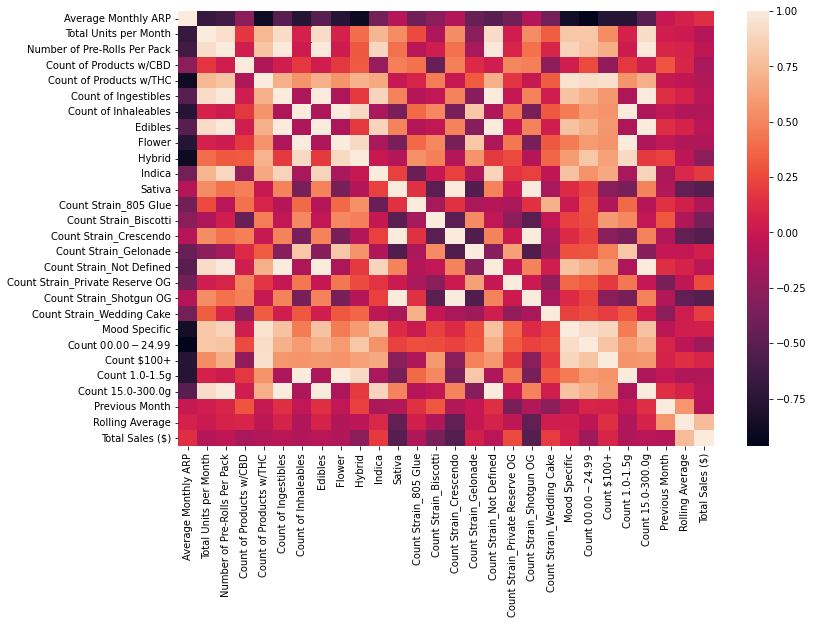

In [ ]:
#Check the correlation matrix on PCA model
import seaborn as sns

corr = pca_df.corr()

plt.subplots(figsize=(12,8))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#Much less colinearity than before

In [441]:
#Metrics for Regression
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Linear Regression

In [444]:
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit, cross_val_score

parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
model = LinearRegression()
kf = KFold()
linear_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=kf)
linear_reg.fit(X_train, y_train)

print("best hyperparam set: ", linear_reg.best_params_)
print("best validation score: ", -linear_reg.best_score_)

best_linear_model = linear_reg.best_estimator_

y_pred_linear = best_linear_model.predict(X_test)

print("MSE: {:.3f}\nMAE: {:.3f}".format( 
                                        mean_squared_error(y_test, y_pred_linear), 
                                        mean_absolute_error(y_test, y_pred_linear)))

results_kfold = model_selection.cross_val_score(linear_reg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print(results_kfold)
print(regression_results(y_test, y_pred_linear))

best hyperparam set:  {'copy_X': True, 'fit_intercept': False}
best validation score:  0.015811365772152603
MSE: 0.010
MAE: 0.102
[-0.02193346 -0.01122345 -0.00723205 -0.01534752 -0.02284044]
explained_variance:  0.9958
mean_squared_log_error:  0.0041
r2:  -1.8527
MAE:  0.1023
MSE:  0.0105
RMSE:  0.1024
None


### Lasso Regularization Regression

In [463]:
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import Lasso

parameters = {'alpha':[0.001, .01, .1, 1, 10]}
model = Lasso(tol=0.01)
tscv = KFold()
lasso_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=tscv)
lasso_reg.fit(X_train, y_train)

print("best hyperparam set: ", lasso_reg.best_params_)
print("best validation score: ", -lasso_reg.best_score_)

best_lasso_model = lasso_reg.best_estimator_

y_pred_lasso = best_lasso_model.predict(X_test)

print("MSE: {:.3f}\nMAE: {:.3f}".format( 
                                        mean_squared_error(y_test, y_pred_lasso), 
                                        mean_absolute_error(y_test, y_pred_lasso)))

results_kfold = model_selection.cross_val_score(lasso_reg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print(results_kfold)
print(regression_results(y_test, y_pred_lasso))

best hyperparam set:  {'alpha': 0.001}
best validation score:  0.015000039256558151
MSE: 0.013
MAE: 0.113
[-0.0236814  -0.01067762 -0.00602218 -0.01431174 -0.03084954]
explained_variance:  0.9999
mean_squared_log_error:  0.0049
r2:  -2.4483
MAE:  0.1126
MSE:  0.0127
RMSE:  0.1126
None


### Ridge Regression

In [447]:
from sklearn.linear_model import Ridge

parameters = {'alpha':[0.001, .01, .1, 1, 10]}
model = Ridge(random_state=42)
tscv = TimeSeriesSplit()
ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=tscv)
ridge_reg.fit(X_train, y_train)

print("best hyperparam set: ", ridge_reg.best_params_)
print("best validation score: ", -ridge_reg.best_score_)

best_ridge_model = ridge_reg.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test)

print("MSE: {:.3f}\nMAE: {:.3f}".format( 
                                        mean_squared_error(y_test, y_pred_ridge), 
                                        mean_absolute_error(y_test, y_pred_ridge)))

results_kfold = model_selection.cross_val_score(ridge_reg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print(results_kfold)
print(regression_results(y_test, y_pred_ridge))

best hyperparam set:  {'alpha': 0.01}
best validation score:  0.02014622205267429
MSE: 0.011
MAE: 0.103
[-0.03474642 -0.01184955 -0.01005903 -0.01416471 -0.02502147]
explained_variance:  0.9977
mean_squared_log_error:  0.0041
r2:  -1.8816
MAE:  0.1029
MSE:  0.0106
RMSE:  0.1029
None


### Decision Tree Regression

In [448]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

kf = KFold()
grid_values = {'ccp_alpha': np.linspace(0, 0.01, 10)}
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='neg_mean_squared_error', cv=kf)

dtr_cv.fit(X_train, y_train)

print("best hyperparam set: ", dtr_cv.best_params_)
print("best validation score: ", -dtr_cv.best_score_)
best_regression_tree = dtr_cv.best_estimator_

y_pred_reg_tree = best_regression_tree.predict(X_test)

print("MSE: {:.3f}\nMAE: {:.3f}".format(mean_squared_error(y_test, y_pred_reg_tree), 
                                        mean_absolute_error(y_test, y_pred_reg_tree)))
results_kfold = model_selection.cross_val_score(dtr_cv, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print(results_kfold)
print(regression_results(y_test, y_pred_reg_tree))

best hyperparam set:  {'ccp_alpha': 0.0022222222222222222}
best validation score:  0.029051651974708548
MSE: 0.020
MAE: 0.135
[-0.06974374 -0.0288057  -0.04715871 -0.0230377  -0.04819605]
explained_variance:  0.5479
mean_squared_log_error:  0.0072
r2:  -4.4123
MAE:  0.135
MSE:  0.0199
RMSE:  0.141
None


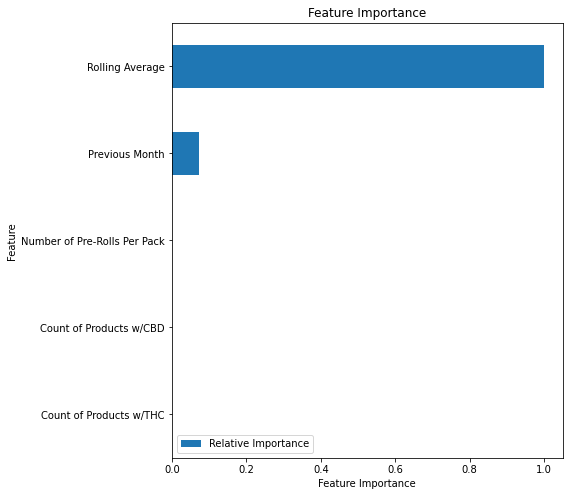

In [462]:
#Create a simple solution to print out the feature importance based on our Decision Tree Regressor
def importance_plot(tree, features):
    feature_importance = tree.feature_importances_
    relative = (feature_importance/feature_importance.max())
    temp_df = pd.DataFrame({'Feature': features, 'Relative Importance': relative})
    
    temp_df = temp_df.sort_values(by=["Relative Importance"], ascending=True).tail(5)
    temp_df.set_index("Feature", inplace=True)
    
    ax = temp_df.plot(kind="barh", figsize=(7, 8))
    ax.set_xlabel('Feature Importance')
    plt.title('Feature Importance')

importance_plot(best_regression_tree, X_train.columns)

### Boosting Regressor

In [452]:
#Experiemented with, and does not work well
from sklearn.ensemble import GradientBoostingRegressor

hyperparams = {'learning_rate': np.linspace(.01, .03, 3),
                'n_estimators' : [25, 50],
                'max_leaf_nodes': np.linspace(2, 10, 5, dtype='int32')
              }

boosting_trees = GradientBoostingRegressor(random_state=42)

tscv = TimeSeriesSplit()
boosting_tree_grid = GridSearchCV(boosting_trees, hyperparams, scoring='neg_mean_squared_error', cv=tscv)

boosting_tree_grid.fit(X_train, y_train)

print("best hyperparam set: ", boosting_tree_grid.best_params_)
print("best validation score: ", -boosting_tree_grid.best_score_)

best_boosting_model = boosting_tree_grid.best_estimator_

y_pred_boosting = best_boosting_model.predict(X_test)

print("MSE: {:.3f}\nMAE: {:.3f}".format(mean_squared_error(y_test, y_pred_boosting), 
                           mean_absolute_error(y_test, y_pred_boosting)))

results_kfold = model_selection.cross_val_score(boosting_tree_grid, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print(results_kfold)
print(regression_results(y_test, y_pred_boosting))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

best hyperparam set:  {'learning_rate': 0.03, 'max_leaf_nodes': 6, 'n_estimators': 50}
best validation score:  0.04131483019312715
MSE: 0.003
MAE: 0.056


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[-0.06601305 -0.0206444  -0.01519427 -0.02853041 -0.03800949]
explained_variance:  0.9901
mean_squared_log_error:  0.0013
r2:  0.1491
MAE:  0.0556
MSE:  0.0031
RMSE:  0.0559
None


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)




---



In [ ]:
#Full Dataframe of Monthly Cookie Sales
cookie_monthly = merge2.drop(columns=['Brands_x', 'Brands_y'])
cookie_monthly.head()

In [ ]:
#Check for unexpected null values
cookie_monthly.isna().sum()

### Cookie Sales Dataset Cleaning

In [ ]:
#Convert months to datetime
cookie_monthly['Months'] = pd.to_datetime(cookie_monthly['Months'])

In [ ]:
#Total sales is too large currently to convert to a float
#need to trim it first then convert to float
cookie_monthly['Total Sales ($)'] = cookie_monthly['Total Sales ($)'].str[:8]
cookie_monthly.loc[:, 'Total Sales ($)'] = cookie_monthly['Total Sales ($)'].str.strip().str.replace(',', '').str.strip()

In [ ]:
#Total units is too large currently to convert to a float
#need to trim it first then convert to float
cookie_monthly['Total Units'] = cookie_monthly['Total Units'].str[:8]
cookie_monthly.loc[:, 'Total Units'] = cookie_monthly['Total Units'].str.strip().str.replace(',', '').str.strip()

In [ ]:
#Convert object-type features to numeric values for modeling
cookie_monthly['Total Sales ($)'] = pd.to_numeric(cookie_monthly['Total Sales ($)'])
cookie_monthly['Total Units'] = pd.to_numeric(cookie_monthly['Total Units'])

### Industry Sales Dataset Cleaning

In [ ]:
#Industry-wide sales dataset merging
industry1 = sales.merge(units, left_on=['Months','Brand'], right_on=['Months','Brands'])
industry_full = industry1.merge(price, on =['Months', 'Brands'])

In [ ]:
#Convert months to datetime
industry_full['Months'] = pd.to_datetime(industry_full['Months'])

In [ ]:
#Total sales is too large currently to convert to a float
industry_full['Total Sales ($)'] = industry_full['Total Sales ($)'].str[:8]
industry_full.loc[:, 'Total Sales ($)'] = industry_full['Total Sales ($)'].str.strip().str.replace(',', '').str.strip()

industry_full['Total Units'] = industry_full['Total Units'].str[:8]
industry_full.loc[:, 'Total Units'] = industry_full['Total Units'].str.strip().str.replace(',', '').str.strip()

#Convert object-type features to numeric values for modeling
industry_full['Total Sales ($)'] = pd.to_numeric(industry_full['Total Sales ($)'])
industry_full['Total Units'] = pd.to_numeric(industry_full['Total Units'])

## Coding Requirement 1.3: Run Basic Stats to Find Correlations between variables
- Run a confusion matrix to see correlation between variables in Cookies dataset


In [ ]:
import seaborn as sns

corr = cookie_monthly.corr()

plt.subplots(figsize=(12,8))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Run Base OLS Model to check for colinearity

In [ ]:
#Remove the target variable from the dataset before pipelining remainder of the dataset
y_base = cookie_monthly[['Total Sales ($)']].copy()
x_base = cookie_monthly.drop(columns=['Total Sales ($)'])

In [ ]:
#Simple pipline just to standardize to check for colinearity
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer, make_column_transformer
imputer = SimpleImputer(strategy="mean") # use mean imputation for missing values
base_num = x_base.drop(['Months', 'Brand'], axis=1) 

# remove categorical features from the numeric values

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler())
    ])

avocado_num_tr = num_pipeline.fit_transform(base_num)
numerical_features = list(base_num)
categorical_features = ['Months']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features)#,
        #("cat", OneHotEncoder(categories='auto'), categorical_features),
    ])

base_prepared = full_pipeline.fit_transform(x_base)

In [ ]:
#Scale the target variable
sc = StandardScaler()
y_base = np.array(y_base)
y_base = y_base.reshape(-1,1)
y_labels = sc.fit_transform(y_base)

In [ ]:
# build the OLS model (ordinary least squares) from the training data
base_stats = sm.OLS(y_labels, base_prepared)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = base_stats.fit()

# do the fit and save regression info (parameters, etc) in results_stats
print(results_stats.summary())

## Coding Requirement 1.4: Feature Extraction & Pipeline
- Choose features 
- Augmentation
- Imputation
- Determine Categorization Strategy
- Scaling

**Features to Add:**

1. Previous Month: The previous months Total Sales
2. Rolling Average: The average Total Units for the previous 3 months
3. Industry Monthly Sales: The total sales by month across all brands, may need to average to normalize 
4. Industry Monthly Units: The total units by month across all brands, may need to average to normalize

### Previous Month Feature

In [ ]:
#Augment the feature for previous month on total units prior to the for loop on each brand
cookie_monthly.loc[:, 'Previous Month'] = cookie_monthly.loc[:, 'Total Sales ($)'].shift(1)

### Rolling Average Feature

In [ ]:
#Augment the Rolling Average Feature on Total Units
cookie_monthly.loc[:, 'Rolling Average'] = cookie_monthly.loc[:, 'Total Units'].rolling(3, min_periods=2).mean()

#Impute the nulls values from the first instances of the Rolling Average where there is no value to be averaged and set as the first instance of total units
cookie_monthly.loc[cookie_monthly['Rolling Average'].isna(), 'Rolling Average'] = cookie_monthly['Total Units']
cookie_monthly.info()

### Industry-based features

In [ ]:
#Augment the monthly Industry average sales in "Industry Total Sales" column
industry_full['Industry Total Sales'] = industry_full.groupby(['Months'])['Total Sales ($)'].transform('mean')

In [ ]:
#Augment the monthly Industry average units in "Industry Total Units" column
industry_full['Industry Total Units'] = industry_full.groupby(['Months'])['Total Units'].transform('mean')

In [ ]:
#Augment the monthly Industry average ARP in "Industry ARP" column
industry_full['Industry ARP'] = industry_full.groupby(['Months'])['ARP'].transform('mean')

### Merge Industry Averages back to Cookies Monthly dataset

In [ ]:
#Drop duplicates and get only the important features augmented
industry_full1 = industry_full[['Months', 'Industry Total Sales', 'Industry Total Units', 'Industry ARP']].drop_duplicates(['Months'])

In [ ]:
#Add industry data to the cookies monthly dataset
cookie_monthly = cookie_monthly.merge(industry_full1, on='Months')

### Check for Necessary Imputation

In [ ]:
#Check for nulls
cookie_monthly.isna().sum()

In [ ]:
#Impute nulls caused by start of dataset
cookie_monthly.loc[cookie_monthly['vs. Prior Period_y'].isna(), 'vs. Prior Period_y'] =  cookie_monthly['ARP']
cookie_monthly.loc[cookie_monthly['Previous Month'].isna(), 'Previous Month'] =  cookie_monthly['Total Units']
cookie_monthly.isna().sum()

In [ ]:
#import cleaned details dataset
#details_clean = pd.read_csv(GOOGLE_DRIVE_PATH + 'CS148_Final_Project/Cleaned_Data/details_cookies_clean.csv')
#details_clean#.loc[:,'Product Description'].value_counts()

## Coding Requirement 1.5: Pipeline

In [ ]:
#Make the month category the new index
cookie_monthly = cookie_monthly.set_index('Months').drop(columns=['Brand'])
#cookie_monthly = cookie_monthly.drop(columns=['Brand'])

In [ ]:
#Remove the target variable from the dataset before pipelining remainder of the dataset
y = cookie_monthly[['Total Sales ($)']].copy()
x = cookie_monthly.drop(columns=['Total Sales ($)'])

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

imputer = SimpleImputer(strategy="mean") # use mean imputation for missing values

data_num = x#.drop(columns=['Months']) #Determine and split the numerical features

#Choose Scaling Strategy
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

df_num_tr = num_pipeline.fit_transform(data_num)
numerical_features = list(data_num)
categorical_features = ['Months']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features)#,
        #("cat", OneHotEncoder(), categorical_features),
    ])

data_prepared = full_pipeline.fit_transform(x)#.toarray()

In [ ]:
#Scale the target variable
sc = StandardScaler()
y = np.array(y)
y1 = y.reshape(-1,1)
y_labels = sc.fit_transform(y1)

In [ ]:
# build the OLS model (ordinary least squares) from the training data
stats = sm.OLS(y_labels, data_prepared)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = stats.fit()
print(results_stats.summary())

### Train/Test Split

In [ ]:
#Create a df from the pipelined array created
data_prepared_df = pd.DataFrame(data=data_prepared, columns=['Total Units', 'vs. Prior Period_x', 'ARP', 'vs. Prior Period_y', 'Previous Month', 'Rolling Average', 'Industry Total Sales', 'Industry Total Units', 'Industry ARP'])
data_prepared_df['Months'] = cookie_monthly.index
data_prepared_df['Total Sales ($)'] = y_labels

In [ ]:
#Train/test split on the months so we can test on the month of september
train_df = data_prepared_df.loc[(data_prepared_df['Months']!='2021-09-01')&(data_prepared_df['Months']!='2021-08-01')].set_index('Months')
test_df = data_prepared_df.loc[(data_prepared_df['Months']=='2021-09-01')|(data_prepared_df['Months']=='2021-08-01')].set_index('Months')

In [ ]:
# create training sets 
y_train = train_df[['Total Sales ($)']]
X_train = train_df.drop(columns=['Total Sales ($)'], axis=1)

In [ ]:
#Create test sets
y_test = test_df['Total Sales ($)']
X_test = test_df.drop(columns=['Total Sales ($)'], axis =1)

In [ ]:
# build the OLS model (ordinary least squares) from the training data
stats = sm.OLS(y_train, X_train)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = stats.fit()
print(results_stats.summary())

In [ ]:
#Update model to remove the features with high p-values
train_df

## Coding Requirement 1.7 Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

# fit a model
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [ ]:
#Check MSE for linear model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print('MSE For Basic Linear Regression Model', mse)

## Coding Requirement 1.8: PCA

In [ ]:
from sklearn import decomposition
from sklearn.decomposition import PCA
# First we create a PCA object with the 4 components as a parameter
pca = decomposition.PCA(n_components=7)

# Now we run the fit operation to convert our 
# data to a PCA transformmed data
pca.fit_transform(np.asarray(train_df))
cookies_pca = pd.DataFrame(pca.components_,columns=train_df.columns,index = ['PC-1','PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7'])
cookies_pca

In [ ]:
#New PCA X&Y train
pca_y = cookies_pca['Total Sales ($)']
pca_x = cookies_pca.drop(columns=['Total Sales ($)'])

In [ ]:
#rerun train test split for updated pca dataset
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(pca_x, pca_y)

In [ ]:
#retest
model2 = lm.fit(new_X_train, new_y_train)
predictions2 = lm.predict(new_X_train.iloc[0:2,:])

#new mse
mse2 = mean_squared_error(new_y_test, predictions2)
print('MSE For PCA Model: ' , mse2)

## Coding Requirement 1.9: Implement Ensemble Methods

In [ ]:
import seaborn as sns

corr = train_df.corr()

plt.subplots(figsize=(12,8))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
import statsmodels.api as sm
# build the OLS model (ordinary least squares) from the training data
stats = sm.OLS(new_y_train, new_X_train)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = stats.fit()
print(results_stats.summary())

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#lasso
parameters = {'alpha':[0.001, .01, .1, 1, 10]}
model = Lasso(tol=0.01)
tscv = TimeSeriesSplit()
lasso_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=tscv)
lasso_reg.fit(new_X_train, new_y_train)

print("best hyperparam set: ", lasso_reg.best_params_)
print("best validation score: ", -lasso_reg.best_score_)
best_lasso_model = lasso_reg.best_estimator_

y_pred_lasso = best_lasso_model.predict(new_X_test)

print("R^2: {:.3f}\nMSE: {:.3f}".format(r2_score(new_y_test, y_pred_lasso), 
                                        mean_squared_error(new_y_test, y_pred_lasso)))

ValueError: ignored

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

tscv = TimeSeriesSplit()
grid_values = {'ccp_alpha': np.linspace(0, 0.01, 10)}
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='neg_mean_squared_error', cv=tscv)

dtr_cv.fit(X_train, y_train)

print("best hyperparam set: ", dtr_cv.best_params_)
print("best validation score: ", -dtr_cv.best_score_)
y_pred_reg_tree = best_regression_tree.predict(X_test)

#print('OSR2:', OSR2(best_regression_tree, X_test, y_test, y_train))
print("R^2: {:.3f}\nMSE: {:.3f}".format(r2_score(y_test, y_pred_reg_tree), 
                                        mean_squared_error(y_test, y_pred_reg_tree)))

## Coding Requirement 1.10 & 1.11: Cross Validate, KFold, and Grid Search

In [ ]:
from sklearn.model_selection import KFold
from sklearn import model_selection

In [ ]:
x = [1,2,3,4,5,6,7,8,9,10,11,12]
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(x):
    print ("TRAIN:", train_index, "TEST:", test_index)

In [ ]:
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(data_prepared):
    print("TRAIN:", train_index, "TEST:", test_index)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#DecisionTreeRegressor
#LinearRegression
#LASSO
#RIDGE

# First we define our cross-validation model parameters. In this case we're going to use KFold, with 10 splits
# where we first shuffle our data before splitting it, and use a random seed to ensure a consistent repeatable shuffle
kfold = model_selection.KFold(n_splits=10, random_state=None, shuffle=True) 

# Next we define the classifier we will be using for our model (we simply reuse the one we used previously)
model_kfold = DecisionTreeRegressor()

# Finally we pull it all together. We call cross val score to generate an accuracy performance score for our model
# we define our learning model, data, labels, and cross-val splitting strategy (all defined previously)
results_kfold = model_selection.cross_val_score(model_kfold, data_prepared, y_labels.ravel(), cv=kfold, scoring='neg_mean_squared_error')
print(results_kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean())) 

#grid search 
grid_values = {'ccp_alpha': np.linspace(0, 0.01, 10)}
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='neg_mean_squared_error', cv=kfold)

y_pred_reg_tree = best_regression_tree.predict(X_test)

#print('OSR2:', OSR2(best_regression_tree, X_test, y_test, y_train))
print("R^2: {:.3f}\nMSE: {:.3f}".format(r2_score(y_test, y_pred_reg_tree), 
                                        mean_squared_error(y_test, y_pred_reg_tree)))

# Because we're collecting results from all runs, we take the mean value
print("Accuracy: %.2f%%" % (results_kfold.mean())) 